# SSP Tactile Encoding
This demo illuistrates the memorization and replay of spatial tactile perception.

In [1]:
%matplotlib inline
from functools import partial

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import nengo
import nengo_spa as spa
import numpy as np
import seaborn as sns
from IPython.display import HTML, display
from nengo_extras.plot_spikes import plot_spikes, preprocess_spikes
from skimage.draw import disk, rectangle
from sklearn.decomposition import PCA

from ssp.dynamics import Trajectory
from ssp.interface import Object
from ssp.maps import Spatial2D
from ssp.plots import create_gif, heatmap_animation

2023-11-01 16:02:10.175212: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 16:02:10.175269: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 16:02:10.177553: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 16:02:10.322193: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 16:02:11.403930: W tensorflow/compiler/

In [2]:
class StimulusGenerator2D:
    """Generates a 2D field with stimuli of a given profile."""

    def __init__(self, dim=(256,), sample_dim=(20,), profile=("ring", 150, 10)):
        try:
            if len(dim) < 2:
                dim = (dim[0], dim[0])
        except:
            dim = (dim, dim)
        try:
            if len(sample_dim) < 2:
                sample_dim = (sample_dim[0], sample_dim[0])
        except:
            sample_dim = (sample_dim, sample_dim)
        self.dim = np.asarray(dim)
        self.sample_dim = np.asarray(sample_dim)
        self.__field = np.zeros((dim[0], dim[1], 3))

        match profile:
            case tuple():
                match profile[0]:
                    case "ring":
                        r0, c0 = disk((dim[1] // 2, dim[0] // 2), profile[1])
                        self.__field[r0, c0] = (1, 1, 1)
                        r1, c1 = disk(
                            (dim[1] // 2, dim[0] // 2), profile[1] - profile[2]
                        )
                        self.__field[r1, c1] = (0, 0, 0)
                    case "square":
                        start = self.dim[:2] // 2 - profile[1] // 2
                        end = start + profile[1]
                        r0, c0 = rectangle(start, end)
                        self.__field[r0, c0] = (1, 1, 1)
                        r1, c1 = rectangle(start + profile[2], end - profile[2])
                        self.__field[r1, c1] = (0, 0, 0)
            case _:
                pass

        self.annotation = {"thickness": 2}

    @property
    def field(self):
        return self.__field

    def sample(self, point):
        """Samples the stimulus field at the given locations.

        Args:
            locations (array like): Array of locations to sample from.

        Returns:
            tuple: Tuple of sampled stimulus and annotated field.
        """
        start = np.asarray(point, dtype=int)
        end = start + self.sample_dim
        thickness = self.annotation["thickness"]
        # Plots annotation rectangle
        ann = np.copy(self.field)
        r0, c0 = rectangle(start, end=end, shape=self.field.shape)
        ann[r0, c0] = (1, 0, 0)
        r1, c1 = rectangle(
            start + thickness,
            end=end - thickness,
            shape=self.field.shape,
        )
        ann[r1, c1] = self.field[r1, c1]
        sample = np.copy(self.field[start[0] : end[0], start[1] : end[1]])
        return sample, ann


def create_animation(
    figures,
    titles=None,
    interval=100,
    cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True),
):
    """Auxiliary function to create an animation of lists of figures.

    Args:
        samples (array like): Samples of the stimulus.
        annotations (array like): Annotated field of the stimulus.
        interval (int, optional): Delay between frames in milliseconds.. Defaults to 100.
        cmap (palette, optional): Seaborn palette. Defaults sns.diverging_palette(220, 20, sep=20, as_cmap=True).

    Returns:
        _type_: _description_
    """
    if not isinstance(figures, list | np.ndarray):
        figures = np.asarray([figures])

    fig, axes = plt.subplots(1, len(figures), figsize=(6 * len(figures), 6))
    if len(figures) == 1:
        axes = [axes]
    n_steps = len(figures[0])
    images = []
    for step in range(n_steps):
        frame = []
        for i, figure in enumerate(figures):
            frame.append(axes[i].imshow(figure[step], cmap=cmap, animated=True))

        images.append(frame)
    if titles is not None:
        for i in range(len(axes)):
            axes[i].set_title(titles[i])
    ani = animation.ArtistAnimation(fig, images, interval=interval, blit=True)
    plt.tight_layout()
    plt.close()
    return ani


def get_orientation(sample):
    data = np.sum(sample, axis=2)
    ys, xs = np.where(data > 0)
    if len(ys) > 0:
        mean = ys.mean(dtype=int), xs.mean(dtype=int)
        ys -= mean[0]
        xs -= mean[1]
        X = np.stack([ys, xs]).T
        pca = PCA(n_components=2).fit(X)
        # mean in (y, x)-coord
        # mean, pca.explained_variance_, pca.components_
        angles = np.arctan2(pca.components_[:, 0], pca.components_[:, 1])
    else:
        angles = (0,)

    return angles

# Accurate representation for spatial cognition using grid cells
Nicole Sandra-Yaffa Dumont & Chris Eliasmith

In [3]:
def ssp_plane_basis(K):
    # Create the bases vectors X,Y as described in the paper with the wavevectors
    # (k_i = (u_i,v_i)) given in a matrix K. To get hexganal patterns use 3 K vectors 120 degs apart
    # To get mulit-scales/orientation, give many such sets of 3 K vectors
    # K is _ by 2
    d = K.shape[0]
    FX = np.ones((d * 2 + 1,), dtype="complex")
    FX[0:d] = np.exp(1.0j * K[:, 0])
    FX[-d:] = np.flip(np.conj(FX[0:d]))
    FX = np.fft.ifftshift(FX)
    FY = np.ones((d * 2 + 1,), dtype="complex")
    FY[0:d] = np.exp(1.0j * K[:, 1])
    FY[-d:] = np.flip(np.conj(FY[0:d]))
    FY = np.fft.ifftshift(FY)

    X = spa.SemanticPointer(data=np.fft.ifft(FX).real)
    Y = spa.SemanticPointer(data=np.fft.ifft(FY).real)
    return X, Y


def generate_grid_cell_basis(n_scales, n_rotates, scale_min=0.5, scale_max=1.8):
    """Generates basis vectors with ``d = n_scales * n_rotates * 6 + 1``."""
    K_hex = np.array([[0, 1], [np.sqrt(3) / 2, -0.5], [-np.sqrt(3) / 2, -0.5]])

    # Combining multiple n_scales sets of 3 wave vectors that give hexagonal grid interference patterns
    # each set of 3 giving a different grid resolution
    scales = np.linspace(scale_min, scale_max, n_scales)
    K_scales = np.vstack([K_hex * i for i in scales])

    # Combining multiple n_rotates sets of 3 wave vectors that give hexagonal grid interference patterns
    # each set of 3 giving a different grid orientation
    thetas = np.arange(0, n_rotates) * np.pi / (3 * n_rotates)
    R_mats = np.stack(
        [
            np.stack([np.cos(thetas), -np.sin(thetas)], axis=1),
            np.stack([np.sin(thetas), np.cos(thetas)], axis=1),
        ],
        axis=1,
    )
    # TODO: don't double transpose
    K_rotates = (R_mats @ K_hex.T).transpose(1, 2, 0).T.reshape(-1, 2)

    # Multiple resolutions and orientations
    # TODO: don't double transpose
    K_scale_rotates = (R_mats @ K_scales.T).transpose(1, 2, 0).T.reshape(-1, 2)

    # Generate the (X, Y) basis vectors
    X, Y = ssp_plane_basis(K_scale_rotates)
    d = n_scales * n_rotates * 6 + 1
    assert len(X) == len(Y) == d
    return X, Y, d

In [41]:
from ssp.pointers import BaseVectors


class Tac2D:
    def __init__(
        self,
        dim,
        scale=10,
        decode_threshold=0.5,
        unitary=True,
        X=None,
        Y=None,
        rng=np.random.RandomState(),
    ):
        self.dim = dim
        self.voc = spa.Vocabulary(self.dim, pointer_gen=BaseVectors(self.dim, rng=rng))
        self.scale = scale
        self.decode_threshold = decode_threshold
        self.unitary = unitary  # note: only applies to axis representations
        self.rng = rng

        # initial object names, map axes and trajectory encoding cue
        for key in ["ZERO", "IDENTITY"]:
            self.voc.populate(key + ".unitary()" if unitary else "")

        self.Zero = self.voc["ZERO"]
        self.One = self.voc["IDENTITY"]

    def encode_orientation(self, radian):
        if not isinstance(radian, list | np.ndarray):
            radian = [radian]

        enc = []
        for rad in radian:
            if rad == 0:
                e = self.voc["ZERO"]
            else:
                e = self.voc["IDENTITY"] ** (rad * self.scale)
            enc.append(e)

        return enc


tac2d = Tac2D(dim=64)
radians = [0, 1, 2, np.pi]
enc = tac2d.encode_orientation(radians)
enc

[SemanticPointer(array([ 0.0153991 , -0.06383866,  0.12880597,  0.22249253, -0.10256976,
         0.16578005,  0.14069901, -0.0384887 ,  0.19949095,  0.02276105,
        -0.02197964,  0.03793262,  0.1071855 , -0.1291979 , -0.12873231,
         0.09517104,  0.05000631, -0.10446157, -0.04387726, -0.01455099,
        -0.01629575,  0.1431859 ,  0.14795847,  0.08615981, -0.17324102,
         0.18562791,  0.02811351,  0.23923144,  0.14840908, -0.13785022,
        -0.06471145, -0.00776112,  0.23565474,  0.00597754, -0.06070619,
        -0.06601586,  0.27010384, -0.11339913,  0.18298045,  0.01242133,
         0.16358522, -0.01623625, -0.32780671, -0.12620671, -0.11159313,
        -0.18214986,  0.12993838,  0.02912343,  0.18762268, -0.00297561,
         0.00897336, -0.1238855 ,  0.00346849, -0.15784883,  0.05993305,
         0.12548785, -0.18077189, -0.03005633,  0.00376349, -0.06300443,
        -0.05942114, -0.02556264,  0.07961465,  0.03213781]), vocab=<nengo_spa.vocabulary.Vocabulary object 

In [ ]:
# Simulator parameters
field_dim = 200
sample_dim = 15
n_samples = 50
speed = 5

# points in the simulation are within [0, 1]^2 and then visualized
# on [-0.5, 0.5]^2 with a scale of sqrt(2)*grid_size such
# that the diameter of each ball is roughly the same scale
grid_size = 10
ssp_radius = np.sqrt(2)  # open problem: deriving this
ssp_scale = ssp_radius * grid_size

X, Y, d = generate_grid_cell_basis(
    n_scales=10, n_rotates=9, scale_min=0.9, scale_max=3.5
)
dim = d
print("Dimensionality:", d)

ssp_map = Spatial2D(dim=dim, scale=ssp_scale, X=X, Y=Y, rng=rng)

ssp_map.build_grid(x_len=1, y_len=1, x_spaces=field_dim, y_spaces=field_dim)

In [5]:
ssp_map.reset()
SG2D = StimulusGenerator2D(
    dim=field_dim, sample_dim=sample_dim, profile=("square", 150, 5)
)
sampled = []
annotated = []
mems = []
locations = [(160, 100)]
pp = locations[-1]
explore_state = 0
aux = []
while explore_state != -1 and explore_state < n_samples:
    p0 = locations[-1]
    sa, ann = SG2D.sample(p0)
    sampled.append(sa)
    annotated.append(ann)
    angle = get_orientation(sa)[0]

    # Compute motion
    dp0 = speed * np.asarray([np.sin(angle + np.pi), np.cos(angle + np.pi)])
    dp1 = speed * np.asarray([np.sin(angle), np.cos(angle)])
    p00 = p0 + dp0
    p01 = p0 + dp1
    if np.linalg.norm(p00 - pp) > np.linalg.norm(p01 - pp):
        p1 = p00
    else:
        p1 = p01

    # Update memory
    x, y = np.asarray(p0) / field_dim
    if sa.sum() > 1:
        ssp_map.add_point(x, y)
    mems.append(ssp_map.heatmap_scores)

    diff = p1 - locations[0]
    aux.append(np.arctan2(diff[0], diff[1]))
    pp = locations[-1]
    locations.append(p1)
    if np.linalg.norm(p1 - locations[0]) <= 0.1:
        explore_state = -1
    else:
        explore_state += 1

ani = create_animation([sampled, annotated, mems], titles=["ROI", "Field", "Memory"])
ani.save("touch_sim.mp4", writer=animation.FFMpegWriter(fps=10))
display(HTML(ani.to_jshtml()))

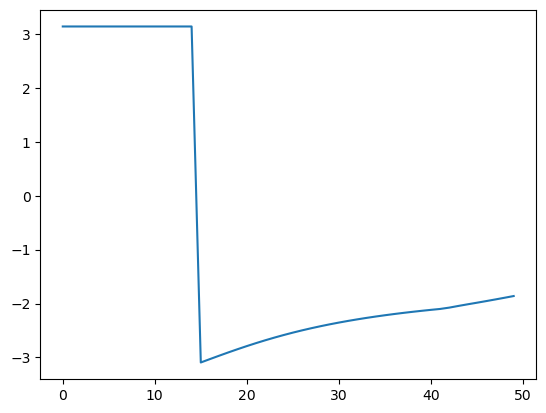

In [7]:
plt.figure()
plt.plot(aux)
plt.show()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

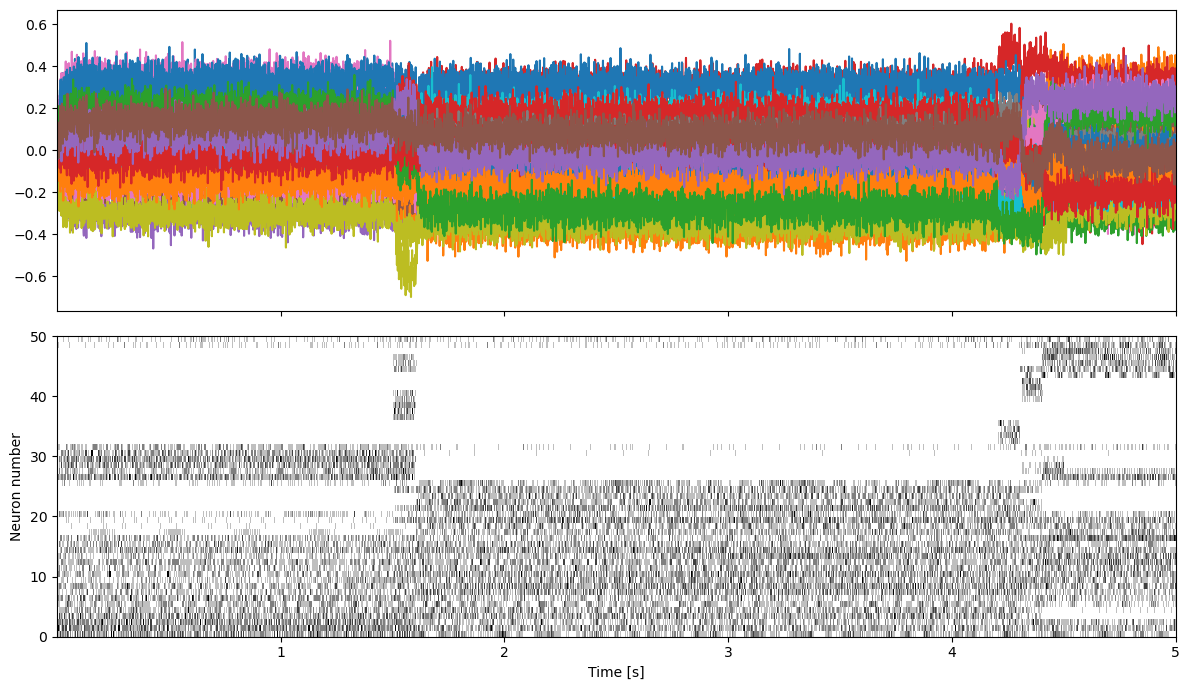

In [6]:
stimuli = np.sum(sampled, axis=3)
stimuli = (stimuli - stimuli.min()) / (stimuli.max() - stimuli.min())
input_dim = stimuli.shape[1] * stimuli.shape[2]
n_samples = stimuli.shape[0]
duration = 0.1  # in seconds
time = n_samples * duration  # in seconds

with nengo.Network() as model:
    inp = nengo.Node(
        output=lambda t: stimuli[int(t / duration) % stimuli.shape[0]].flatten()
    )
    ens = nengo.Ensemble(n_neurons=stimuli[0].size, dimensions=36)
    nengo.Connection(inp, ens.neurons)
    p = nengo.Probe(ens, synapse=0.01)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(model, dt=1e-3) as sim:
    sim.run(time)

dig, axs = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
axs[0].plot(sim.trange(), sim.data[p])
plot_spikes(*preprocess_spikes(sim.trange(), sim.data[p_spikes]), ax=axs[1])
axs[1].set_ylabel("Neuron number")
plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()